<a href="https://colab.research.google.com/github/chieuanh2910/WeatherForecast/blob/main/Weather_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## Weather forecasting with time-series data

## Table of Content

1. [Executive Summary](#cell_Summary)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Predictive Modeling](#cell_model)

4. [Experiments Report](#cell_report)



<a id = "cell_Summary"></a>
## 1. Executive Summary

This analysis represents a multivariate time-series forecast of two-week mean temperature in the city of Delhi from 2013 to 2017. The objectives inlcude data exploration, visualization, and forcasting with the target being the daily mean temperature for 14 days ahead.

The structrure of the analysis includes Data Preprocessing, Prediticve Modeling, and Experiemnts Report

**Data Preprocessing**

This section involves data exploration to understand the characteristics of the provided dataset. This included visualizing time series patterns and normalizing data values to scale 0-1. The dataset is then divided into a training set, encompassing data from 2013 to 2016, and a testing set consisting of data from 2017.

**Predictive Modelling**

A Recurrent Neural Networks (RNN) is designed and implemented to conduct the time-series forecasting. The model leverages the temporal patterns present in the dataset to make predictions for the next two weeks.

**Model Evaluation**

To evaluate the forecasting model's performance, the testing dataset is data in 2017. Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE), were computed to assess the accuracy and reliability of the forecasts. The results provide insights on how reliable the model is able to capture temperature variations and make predictions for the specified horizon.

**Experiments Report**

While the initial model provides promising results, there is room for improvement in several areas:

Hyperparameter Tuning: Fine-tuning hyperparameters such as the model architecture, learning rate, and batch size may enhance forecasting accuracy.
Feature Engineering: Further feature engineering, including the incorporation of external variables like humidity, wind speed, and precipitation, could improve the model's predictive power.
Ensemble Techniques: Exploring ensemble methods or hybrid models that combine deep learning with traditional time series forecasting approaches may yield better results.
Advanced Deep Learning Architectures: Experimenting with more complex deep learning architectures, such as Long Short-Term Memory (LSTM) networks or Gated Recurrent Units (GRUs), could capture long-term dependencies more effectively.
Additional Data Sources: Incorporating data from other sources, such as satellite imagery or climate indices, may enhance the model's forecasting capabilities.

In summary, this analysis aims to develope and evaluate a deep learning model for forecasting the mean daily temperature in Delhi with a two-week horizon. The results could help business such as F&B industry to have better understanding of weather forecasting in Delhi and have good plannings to introduce new foods or beverages in time, or better inventory management to avoid high costs of ingredients during off seasons.

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

The dataset consists of 1575 rows with 5 attributes: date, meantemp, humidmity, wind_speed, and meanpressure. 'date' attribute will be set as index to perform time-series forecast. There is no null value in this dataset.

Based on the visualizations, it seems that mean temperature rises at first half of the years and will decrease at the other half. June or July has the highest mean temperature. On the other hand, humidity peaks at the begining and end months of the year while it is lowest in June or July. Wind_speed share similar patterns to meantemp but there is different in December when the values are highest. Therefore, there seems to be seasonal trends for the attributes: meantemp, humidity, and wind_speed. There is no particular trend for meanpressure, except it is highest in March or April 2016, and there are some fluctuation to below 0 in 2017.

Before implementing the RNN model, the dataset will be split for trainning with data from 2013 to 2016, and testing with data in 2017. The training set include 1261 samples while the test set has 114 samples. All data will be normalized to the range of 0-1.

In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/A2_Datasets/Part3_Weather.csv', index_col='Date', parse_dates=["Date"], dayfirst=True, infer_datetime_format=True)
df.head()

,meantemp,humidity,wind_speed,meanpressure
Date,,,,
2013-01-01,10.000000,84.500000,0.000000,10.156667
2013-01-02,7.400000,92.000000,2.980000,10.178000
2013-01-03,7.166667,87.000000,4.633333,10.186667
2013-01-04,8.666667,71.333333,1.233333,10.171667
2013-01-05,6.000000,86.833333,3.700000,10.165000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1575 entries, 2013-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1575 non-null   float64
 1   humidity      1575 non-null   float64
 2   wind_speed    1575 non-null   float64
 3   meanpressure  1575 non-null   float64
dtypes: float64(4)
memory usage: 61.5 KB


In [ ]:
df.isnull().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Text(0.5, 1.0, 'Mean Pressure')

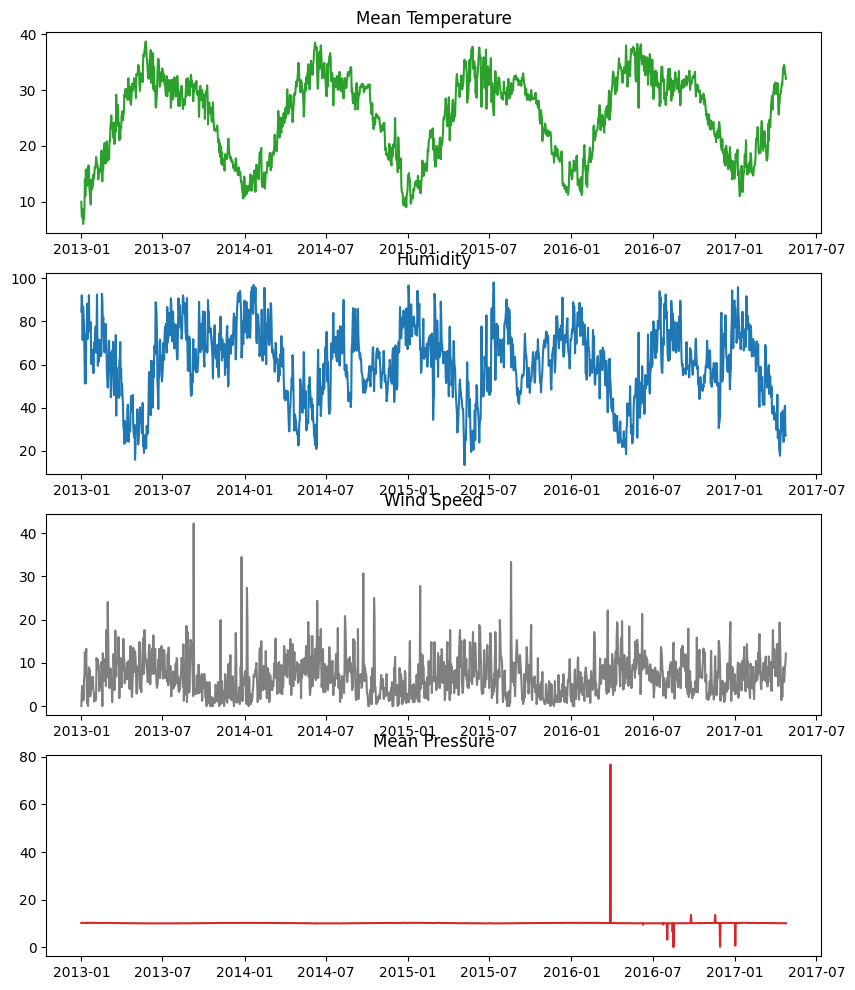

In [ ]:
fig, axs = plt.subplots(4, 1,figsize=(10, 12))
axs[0].plot(df['meantemp'],'tab:green')
axs[0].set_title('Mean Temperature')
axs[1].plot(df['humidity'],'tab:blue')
axs[1].set_title('Humidity')
axs[2].plot(df['wind_speed'],'tab:grey')
axs[2].set_title('Wind Speed')
axs[3].plot(df['meanpressure'],'tab:red')
axs[3].set_title('Mean Pressure')


In [ ]:
tstart = 2013
tend = 2016

def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}"]
    test = dataset.loc[f"{tend+1}":]
    return train, test
training_set, test_set = train_test_split(df, tstart, tend)

In [ ]:
training_set_shape = training_set.shape
test_set_shape = test_set.shape
print('training_set shape:', training_set_shape)
print('test_set shape:', test_set_shape)

training_set shape: (1461, 4)
test_set shape: (114, 4)


In [ ]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.values.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)
print('training_set_scaled shape after scaling:', training_set_scaled.shape)

training_set_scaled shape after scaling: (5844, 1)


In [ ]:
training_set_scaled = training_set_scaled.reshape(training_set_shape[0], training_set_shape[1])
print('training_set_scaled shape:', training_set_scaled.shape)

training_set_scaled shape: (1461, 4)


<a id = "cell_model"></a>
## 3. Predictive Modeling

A function called 'split_sequence' is developed to split the time series into sequences. The number of steps is 90 days and forcasting horizon is 14. The target variable is meantemp which has the index 0. Number of features is 4, equivalent to 4 attributes: meantemp, humidity, wind_speed, meanpressure.

**Model Architecture**

This RNN model has 1 LSTM (Long Short-Term Memory) input layer with 100 units, representing the number of memory cells i this layer. The input shape include 90 number of steps and 4 features. The model has 1 output layer with 14 units representing the forcasting horizon. The model use 'Adam' asthe optimizer with the learning rate 0.001. The loss function is Mean Squared Error (MSE).

**Model Summary**

*  LSTM layer: 100 units, 42000 trainable parameters
*  Dense Layer: 14 units, 1414 trainable parameters

Total Parameters: 43,414

Trainable Parameters: 43,414

Non-trainable Parameters: 0

**Model Evaluation**



In [ ]:
def split_sequence(sequence, n_steps,forecasting_horizon, y_index):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - forecasting_horizon:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+forecasting_horizon,y_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
n_steps = 90
forecasting_horizon = 14
features = 4
y_index = 0 # the index of meantemp column
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps,forecasting_horizon,y_index)

In [ ]:
# Reshaping X_train for model
y_train  = y_train.reshape(y_train .shape[0],y_train.shape[1],1)

In [ ]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (1358, 90, 4)
y_train shape: (1358, 14, 1)


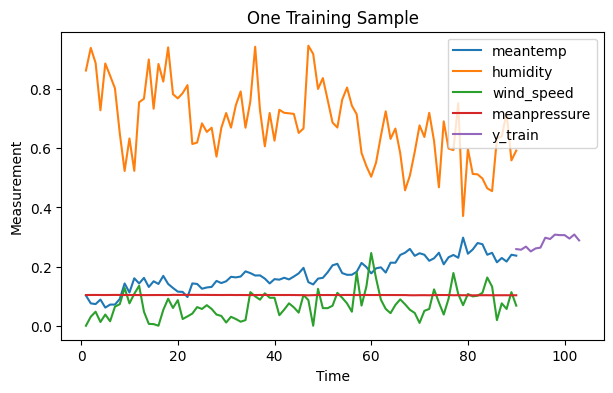

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,0])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,1])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,2])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,3])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),y_train[0])
plt.title('One Training Sample')
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['meantemp','humidity','wind_speed','meanpressure', 'y_train'])

In [ ]:
np.random.seed(29)
tf.random.set_seed(29)

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop

# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=14))
# Compiling the model
model_lstm.compile(optimizer=Adam(learning_rate = 0.001), loss="mse")

model_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               42000     
                                                                 
 dense_6 (Dense)             (None, 14)                1414      
                                                                 
Total params: 43,414
Trainable params: 43,414
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
43/43 [==============================] - 2s 8ms/step - loss: 0.0138
Epoch 2/100
43/43 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 3/100
43/43 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 4/100
43/43 [==============================] - 0s 6ms/step - loss: 9.1252e-04
Epoch 5/100
43/43 [==============================] - 0s 6ms/step - loss: 8.9750e-04
Epoch 6/100
43/43 [==============================] - 0s 6ms/step - loss: 8.5588e-04
Epoch 7/100
43/43 [==============================] - 0s 6ms/step - loss: 8.5628e-04
Epoch 8/100
43/43 [==============================] - 0s 6ms/step - loss: 8.7428e-04
Epoch 9/100
43/43 [==============================] - 0s 5ms/step - loss: 8.2973e-04
Epoch 10/100
43/43 [==============================] - 0s 5ms/step - loss: 7.5160e-04
Epoch 11/100
43/43 [==============================] - 0s 6ms/step - loss: 7.4813e-04
Epoch 12/100
43/43 [==============================] - 0s 6ms/step - loss: 7.8408e-04
E

In [ ]:
#scaling
inputs = test_set.values.reshape(-1, 1)
inputs = sc.transform(inputs)
#Reshape back to orignal format after rescaling
inputs = inputs.reshape(test_set_shape[0], test_set_shape[1])

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps,forecasting_horizon,y_index)
number_test_samples = X_test.shape[0]
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_test shape: (11, 90, 4)
y_test shape: (11, 14)


In [ ]:
#prediction
predicted_meantemp = model_lstm.predict(X_test)

#inverse transform the predicted values
predicted_meantemp = sc.inverse_transform(predicted_meantemp)
print('predicted_meantemp shape: ', predicted_meantemp.shape)

#inverse transform the test labels.
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])
y_test = sc.inverse_transform(y_test)

1/1 [==============================] - 0s 323ms/step
predicted_meantemp shape:  (11, 14)


### Model Evaluation

In [ ]:
def return_mae(test, predicted):
    mae = mean_absolute_error(test, predicted)
    print("Mean Absolute Error {:.2f}.".format(mae))

for i in range(forecasting_horizon):
  print("Forecasting Horizon: {} ".format(i))
  return_mae(y_test[:,i],predicted_meantemp[:,i])
  print("")


Forecasting Horizon: 0 
Mean Absolute Error 1.49.

Forecasting Horizon: 1 
Mean Absolute Error 2.36.

Forecasting Horizon: 2 
Mean Absolute Error 1.77.

Forecasting Horizon: 3 
Mean Absolute Error 1.88.

Forecasting Horizon: 4 
Mean Absolute Error 1.69.

Forecasting Horizon: 5 
Mean Absolute Error 1.88.

Forecasting Horizon: 6 
Mean Absolute Error 1.79.

Forecasting Horizon: 7 
Mean Absolute Error 1.67.

Forecasting Horizon: 8 
Mean Absolute Error 1.44.

Forecasting Horizon: 9 
Mean Absolute Error 1.78.

Forecasting Horizon: 10 
Mean Absolute Error 2.20.

Forecasting Horizon: 11 
Mean Absolute Error 1.89.

Forecasting Horizon: 12 
Mean Absolute Error 2.29.

Forecasting Horizon: 13 
Mean Absolute Error 2.16.



In [ ]:
X_test = X_test.reshape(-1, 90)
X_test = sc.inverse_transform(X_test)
X_test = X_test.reshape(number_test_samples, 90,4)

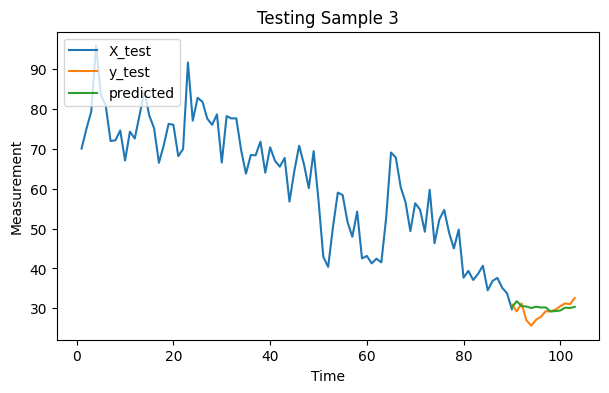

In [ ]:
sample_index = 3

plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, n_steps+1, 1),X_test[sample_index,:,1])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),y_test[sample_index,:])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),predicted_meantemp[sample_index,:])
plt.title('Testing Sample ' + str(sample_index))
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['X_test', 'y_test', 'predicted'], loc='upper left')

<a id = "cell_report"></a>
## 4. Experiments Report


It can be interpreted that optmizer has big impact on the MAE with Adam being the best for this RNN model. On the other hand, number of steps play an important role as well. It is clear that 90 number of steps show better results in comparison to 60 or 30 steps. Smaller batch sizes also lead to lower MAE.

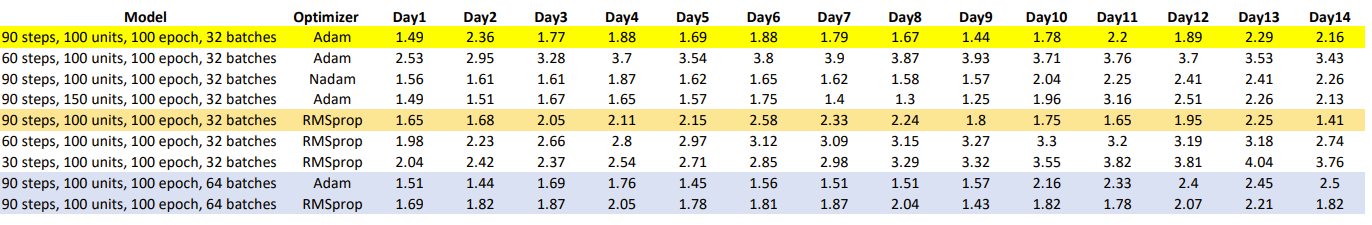
Based on the above observations, to further optimize the model, it highly advisable to experiment with different architectures such as more LSTM layers. Different number of steps should also be experiemented as well as optimizers with different learning rate. Batch size and tranining parameters
tuning such as epoch numbers are also considered in tuning the updated model. Lastly, more data about the weather such as  should be feeded into the dataset. Data attributes such as precipitation, wind direction, solar radiation could help the model to forecast more accurate.

The RNN model proposed in this analysis could help F&B companies to make beter planning in terms of marketing new products relevant to the weather conditions. They can utilize the forecast for inventory managemnet, i.e stocking ingredients to avoid high variable costs if there is a scarce of supply due to environmental reasons.  


